# VCI Predictions for 2011 - 2018

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

# Read in the data

In [41]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

In [290]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [5]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

In [74]:
bline_pred = read_pred_data('previous_month', data_dir)[-1].where(~mask)
lr_pred = read_pred_data('linear_regression', data_dir)[-1].where(~mask)
ln_pred = read_pred_data('linear_network', data_dir)[-1].where(~mask)
rnn_pred = read_pred_data('rnn', data_dir)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir)[-1].where(~mask)
# ealstm_pred = read_pred_data('ealstm', data_dir)

# Explore the train test split

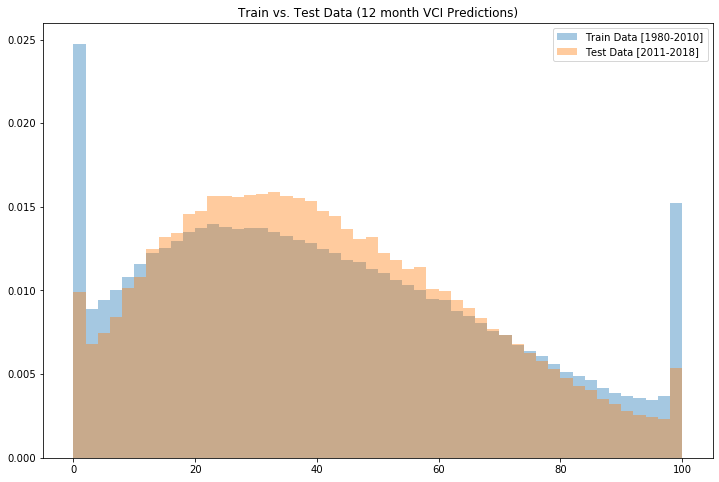

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(
    drop_nans_and_flatten(y_train.VCI), 
    label='Train Data [1980-2010]', 
    kde=False, norm_hist=True
)
sns.distplot(
    drop_nans_and_flatten(y_test.VCI), 
    label='Test Data [2011-2018]', 
    kde=False, norm_hist=True
)

plt.legend()
ax.set_title('Train vs. Test Data (12 month VCI Predictions)');

Text(0.5, 1.0, 'Mean Annual VCI')

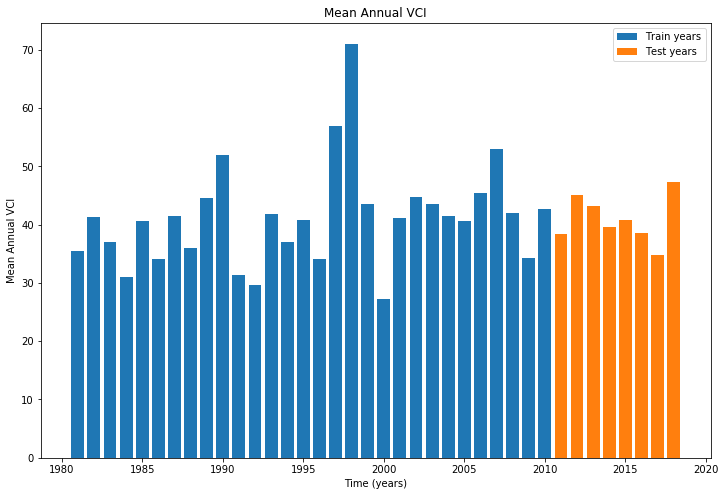

In [43]:
annual_vals = y_train.groupby('time.year').mean(dim=['time', 'lat', 'lon']).VCI.values
years = np.unique(y_train['time.year'].values)

annual_vals_test = y_test.groupby('time.year').mean(dim=['time', 'lat', 'lon']).VCI.values
years_test = np.unique(y_test['time.year'].values)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(height=annual_vals, x=years, label='Train years')
ax.bar(height=annual_vals_test, x=years_test, label='Test years')

plt.legend()
plt.title('Mean Annual VCI')
ax.set_ylabel('Mean Annual VCI')
ax.set_xlabel('Time (years)');
ax.set_title('Mean Annual VCI')

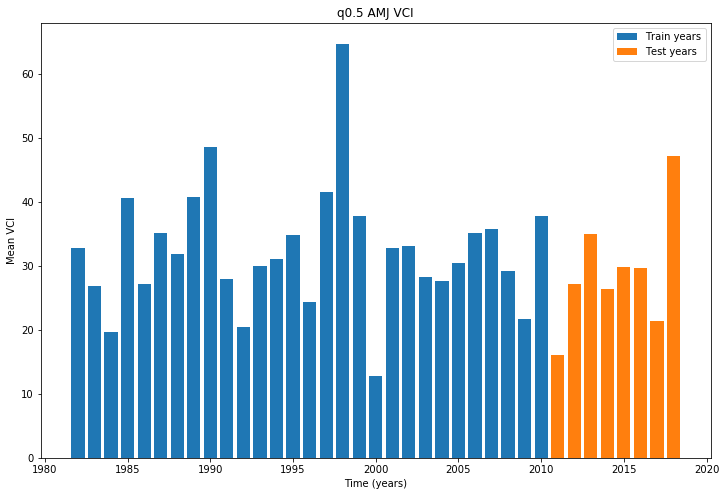

In [44]:
q = 0.5

def is_amj(month):
    return (month >= 4) & (month <= 6)


def is_NDJ(month):
    return (month == 12) | (month == 1) | (month == 2)


annual_vals = (
    y_train.sel(time=is_amj(y_train['time.month']))
    .groupby('time.year')
    .reduce(np.nanpercentile, dim='time', q=q)
    .mean(dim=['lat', 'lon'])
    .VCI
)
years = annual_vals.year.values

annual_vals_test = (
    y_test.sel(time=is_amj(y_test['time.month']))
    .groupby('time.year')
    .reduce(np.nanpercentile, dim='time', q=q)
    .mean(dim=['lat', 'lon'])
    .VCI
)
years_test = annual_vals_test.year.values

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(height=annual_vals.values, x=years, label='Train years')
ax.bar(height=annual_vals_test.values, x=years_test, label='Test years')

plt.legend()
plt.title(f'q{q} AMJ VCI')
ax.set_ylabel('Mean VCI')
ax.set_xlabel('Time (years)');

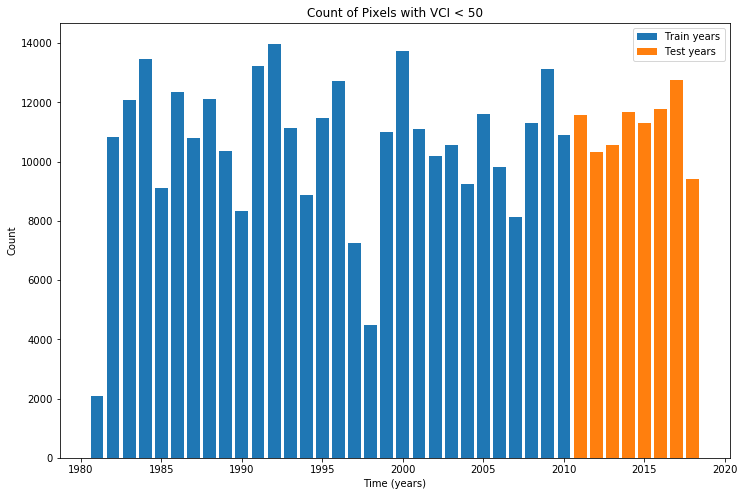

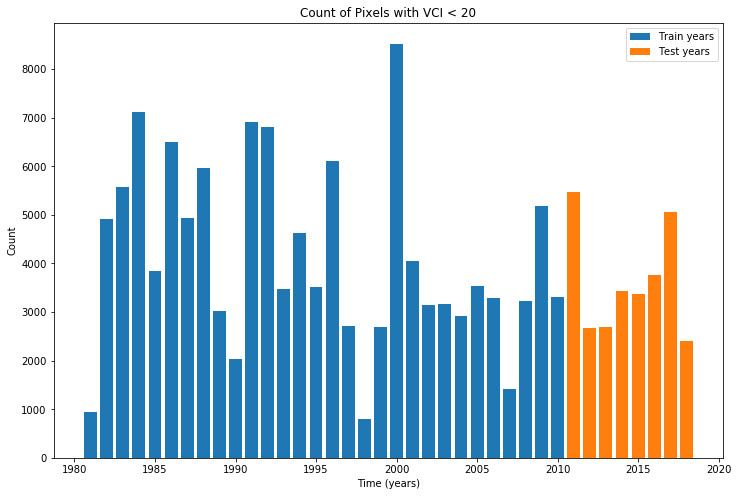

In [47]:
thresh = 50

def plot_train_test_pixels_below_thresh(thresh: float):
    annual_vals = y_train.where(y_train.VCI < thresh).groupby('time.year').count().VCI
    years = annual_vals.year.values

    annual_vals_test = y_test.where(y_test.VCI < thresh).groupby('time.year').count().VCI
    years_test = annual_vals_test.year.values

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(height=annual_vals.values, x=years, label='Train years')
    ax.bar(height=annual_vals_test.values, x=years_test, label='Test years')

    plt.legend()
    plt.title(f'Count of Pixels with VCI < {thresh}')
    ax.set_ylabel('Count')
    ax.set_xlabel('Time (years)');
    
plot_train_test_pixels_below_thresh(thresh=50)
plot_train_test_pixels_below_thresh(thresh=20)

# Show some specific years

In [34]:
import calendar

def plot_annual_maps(month_ds: xr.Dataset, 
                     variable: str, 
                     time_str: str = 'time',
                     **kwargs) -> None:
    fig, axs = plt.subplots(3, 4, figsize=(12, 8))
    for i in range(0, 12):
        da = month_ds.isel({time_str: i})[variable]
        ax_ix = np.unravel_index(i, (3, 4))
        ax = axs[ax_ix]
        da.plot(ax=ax, **kwargs)

        ax.set_title(calendar.month_abbr[i+1])
        ax.set_axis_off()
        
    return fig, ax


def plot_year(year: str, ds: xr.Dataset):
    fig, ax = plot_annual_maps(
        month_ds=ds.sel(time=year), 
        time_str='time', variable='VCI',
        **dict(add_colorbar=False, cmap='RdBu_r', vmin=0, vmax=100)
    )

    fig.suptitle(f'NDVI Anomaly (Obs - Clim) [{year}]');

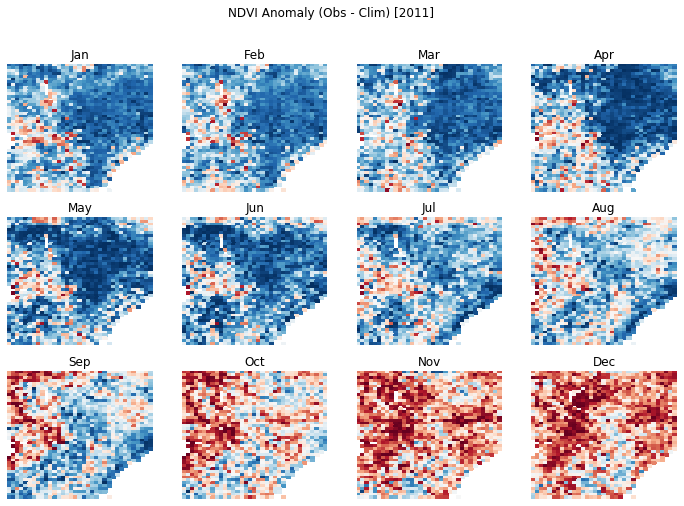

In [37]:
plot_year('2011', y_test)

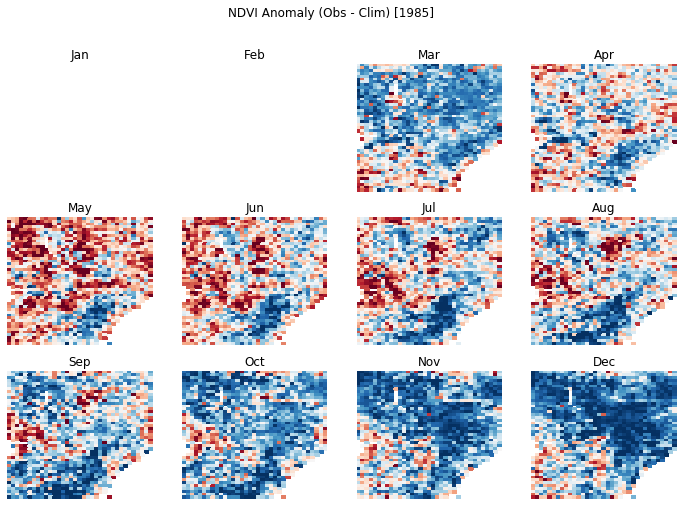

In [49]:
plot_year('1985', y_train)

## Explore predictions

In [55]:
import calendar

obs = y_test.VCI
pred = ealstm_pred
spatial_plot_kwargs = dict(cmap='viridis', vmin=0, vmax=100)


def _plot_single_month_(obs_mth: xr.DataArray, pred_mth: xr.DataArray, month: int) -> None:
    flat_obs = drop_nans_and_flatten(obs_mth)
    flat_pred = drop_nans_and_flatten(pred_mth)

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.distplot(flat_obs, ax=ax, label='Observed')
    sns.distplot(flat_pred, ax=ax, label='Predicted')
    plt.legend();
    ax.get_yaxis().set_visible(False)
    ax.set_title(calendar.month_abbr[month + 1])
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    obs_mth.plot(ax=axs[0], add_colorbar=False, **spatial_plot_kwargs)
    axs[0].set_title('Observed')
    axs[0].set_axis_off()
    pred_mth.plot(ax=axs[1], add_colorbar=False, **spatial_plot_kwargs)
    axs[1].set_title('Predicted')
    axs[1].set_axis_off()
    plt.show()


# def plot_model_performances(month: int, 
#                             obs: xr.DataArray, 
#                             pred: xr.DataArray,
#                             **spatial_plot_kwargs) -> None:
#          obs_mth = obs.groupby(obs.time.dt.month).mean(dim='time').isel(month=month)
#          pred_mth = pred.groupby(pred.time.dt.month).mean(dim='time').isel(month=month)
#         _plot_single_month_(obs_mth, pred_mth)

def plot_year_month_performances(year: int):
    for month in range(0, 12):
        assert (month < 12 ) & (month >= 0), 'Expect month == 0-11'
        assert obs.shape == pred.shape, 'Expect the obs and pred to have the same shape' \
            f'obs: {obs.shape} / pred: {pred.shape}'

        obs_mth = obs.sel(time=str(year)).isel(time=month)
        pred_mth = pred.sel(time=str(year)).isel(time=month)
        _plot_single_month_(obs_mth, pred_mth, month)

In [57]:
# plot_year_month_performances(2011)

## Explore how perform in each month

In [58]:
from src.analysis import annual_scores

In [60]:
# load the monthly scores dictionary
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['previous_month', 'rnn', 'linear_regression', 'linear_network', 'ealstm'],
    metrics=['rmse', 'r2'],
    target_var='VCI',
    verbose=False,
    to_dataframe=True
)

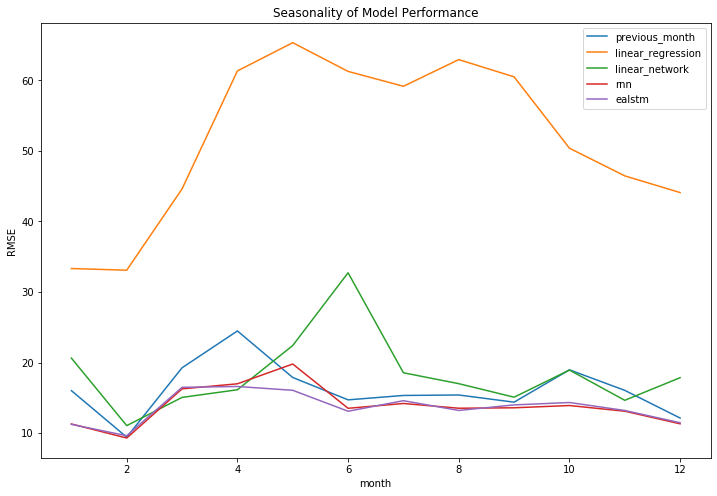

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'linear_regression', 'linear_network', 'rnn', 'ealstm']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance')
ax.set_ylabel('RMSE');

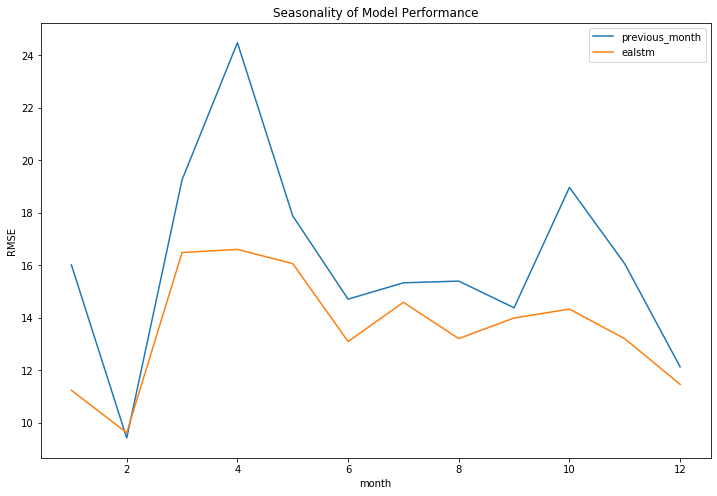

In [66]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'ealstm']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance')
ax.set_ylabel('RMSE');

# Models vs. Observations

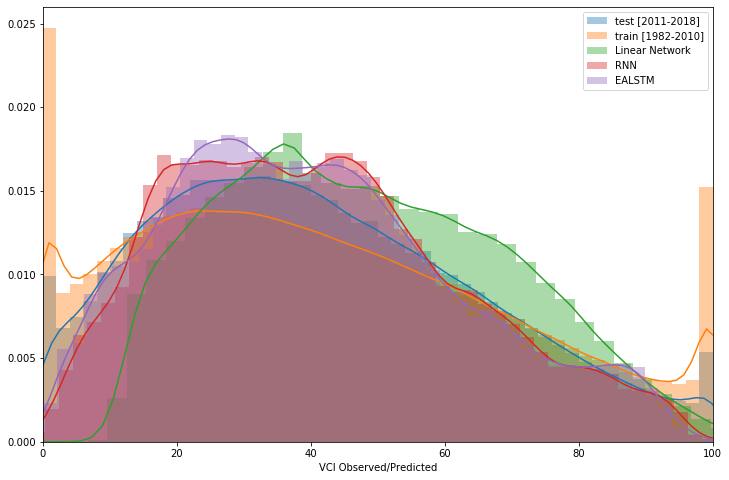

In [79]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test.VCI), ax=ax, label='test [2011-2018]')
sns.distplot(drop_nans_and_flatten(y_train.VCI), ax=ax, label='train [1982-2010]')
# sns.distplot(drop_nans_and_flatten(bline_pred), ax=ax, label='Baseline (persistence)')
# sns.distplot(drop_nans_and_flatten(lr_pred), ax=ax, label='Linear Regression')
sns.distplot(drop_nans_and_flatten(ln_pred), ax=ax, label='Linear Network')
sns.distplot(drop_nans_and_flatten(rnn_pred), ax=ax, label='RNN')
sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='EALSTM')

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted');

### Why is LR so weird?

Linear Regression is basically just predicting 0 for everything. This is a semi-useful finding because it replicates the findings of the NDVI tests (Notebook #23) but it means that the linear regression is not a good model for our problem.

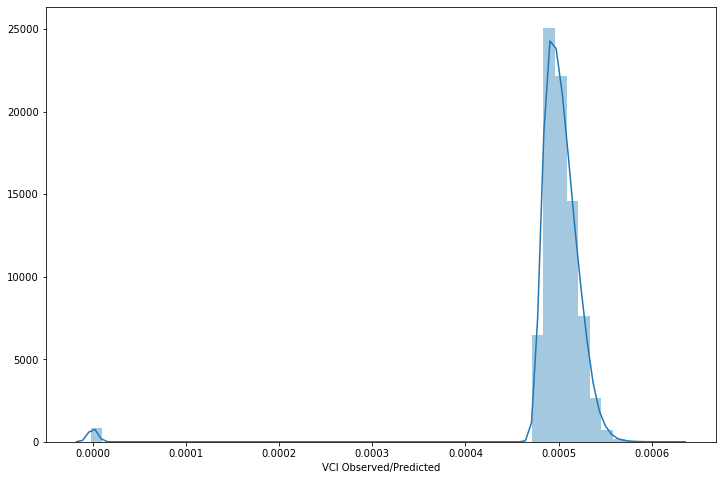

In [80]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(drop_nans_and_flatten(lr_pred), ax=ax, label='Linear Regression')
ax.set_xlabel('VCI Observed/Predicted');

But the spatial patterns are still there which makes me wonder about the implementaiton of the linear regression in the pipeline. Why are the values of predicted VCI so small but the spatial patterns sort of make sense? really weird ...

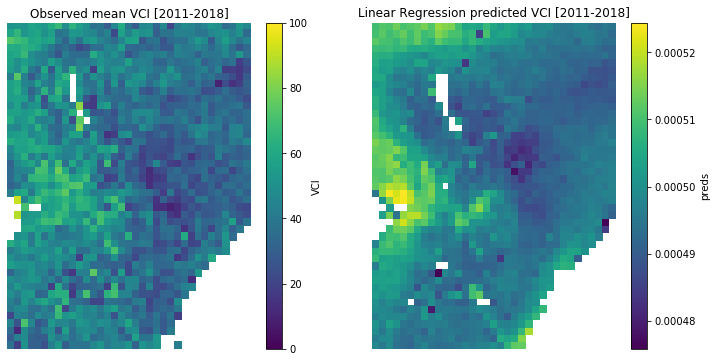

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
y_test.mean(dim='time').VCI.plot(ax=axs[0], cmap='viridis', vmin=0, vmax=100)
lr_pred.mean(dim='time').plot(ax=axs[1])

axs[0].set_title('Observed mean VCI [2011-2018]')
axs[0].set_axis_off()
axs[1].set_title('Linear Regression predicted VCI [2011-2018]')
axs[1].set_axis_off()

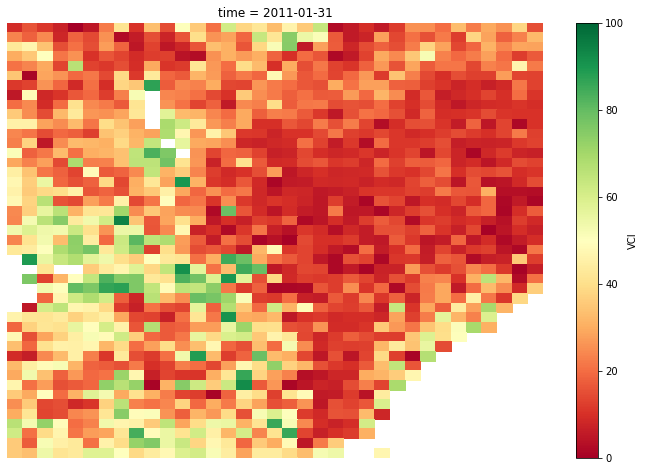

In [385]:
fig, ax = plt.subplots(figsize=(12, 8))
y_test.VCI.isel(time=0).plot(ax=ax, vmin=0, vmax=100, cmap='RdYlGn')
ax.set_axis_off()

### EALSTM vs. Test distributions

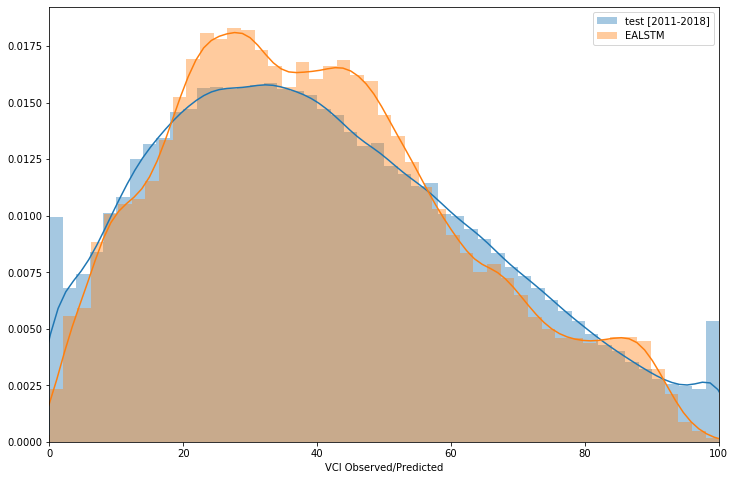

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test.VCI), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.VCI), ax=ax, label='train [1982-2010]')
sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='EALSTM');

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted');

# Model Performance Comparisons

In [86]:
from src.analysis import spatial_rmse, spatial_r2
%autoreload 2

In [91]:
ealstm_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# --------
rnn_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    rnn_pred.transpose("time", "lat", "lon")
)

# --------
ln_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    ln_pred.transpose("time", "lat", "lon")
)

# --------
bline_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# --------
lr_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    lr_pred.transpose("time", "lat", "lon")
)

# calculate mean performance scores
ealstm_mean = ealstm_rmse.mean().values
rnn_mean = rnn_rmse.mean().values
ln_mean = ln_rmse.mean().values
bline_mean = bline_rmse.mean().values
lr_mean = lr_rmse.mean().values

In [97]:
rmses = [bline_rmse, lr_rmse, ln_rmse, rnn_rmse, ealstm_rmse]
means = [bline_mean, lr_mean, ln_mean, rnn_mean, ealstm_mean]
labels = ['Basline','Linear Regression','Linear Network','LSTM','EALSTM']
colors = sns.color_palette()[:len(means)]

assert (len(rmses) == len(means)) &  (len(labels) == len(colors))
assert (len(rmses) == len(labels))

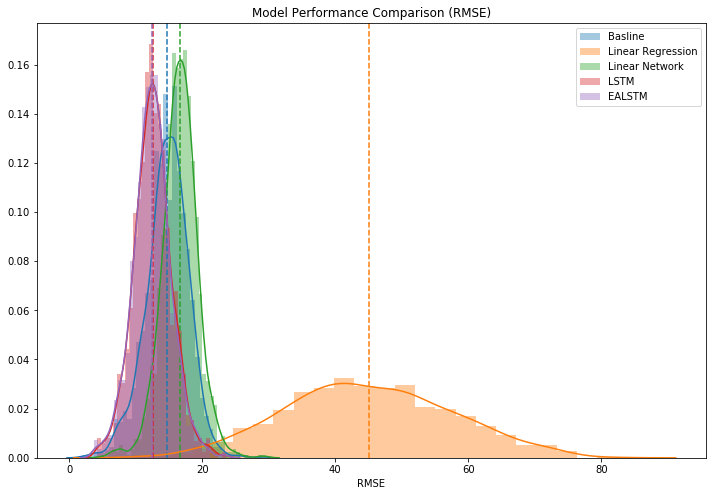

In [101]:
fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(rmses)):
    rmse = rmses[i]
    mean = means[i]
    label = labels[i]
    color = colors[i]
    sns.distplot(
        drop_nans_and_flatten(rmse), ax=ax,
        label=label, color=color
    )
    ax.axvline(mean, ls='--', color=color) # , label=f'{label}_mean'

plt.legend()
ax.set_xlabel('RMSE');
ax.set_title('Model Performance Comparison (RMSE)');
# ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

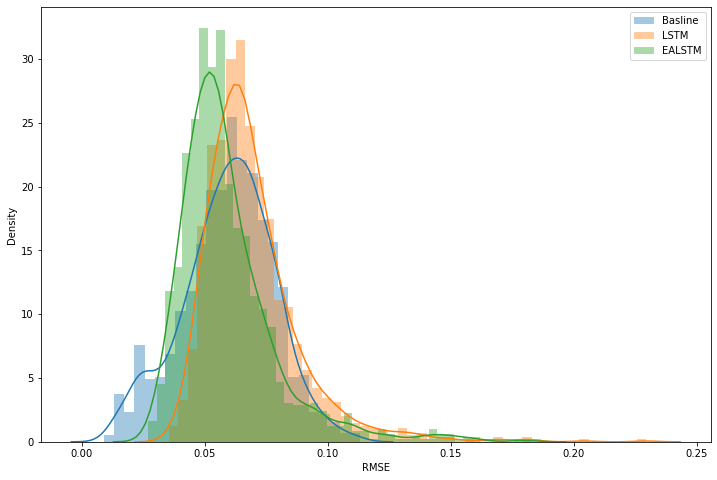

In [209]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(bline_rmse), ax=ax, label='Basline')
# sns.distplot(drop_nans_and_flatten(lr_rmse), ax=ax, label='Linear Regression')
# sns.distplot(drop_nans_and_flatten(ln_rmse), ax=ax, label='Linear Network')
sns.distplot(drop_nans_and_flatten(rnn_rmse), ax=ax, label='LSTM')
sns.distplot(drop_nans_and_flatten(ealstm_rmse), ax=ax, label='EALSTM')

plt.legend()
ax.set_xlabel('RMSE')
ax.set_ylabel('Density'); 

# Regional Analysis

In [103]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)

r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'ealstm_ERA5_128', 'linear_network', 'linear_network_10stopping', 'linear_regression', 'previous_month', 'rnn', 'rnn_10stopping']
Regions: ['district_l2_kenya.nc', 't2m_africa.nc']
Region Type: administrative_boundaries
GroupbyRegion requires geopandas to be installed


In [105]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

In [106]:
da = ds.VCI
region_names = []
true_mean_value = []
datetimes = [pd.to_datetime(t) for t in da.time.values]

region_data_dict = {}
region_data_dict['datetime'] = datetimes

for valid_region_id in valid_region_ids:
    region_vals = da.where(region_da == valid_region_id).mean(dim=['lat', 'lon']).values
    region_data_dict[region_lookup[valid_region_id]] = region_vals

all_df = pd.DataFrame(region_data_dict)
all_df.head()

,datetime,NAIROBI,KIAMBU,KIRINYAGA,MURANGA,NYANDARUA,NYERI,THIKA,MARAGUA,KILIFI,...,WEST POKOT,BURET,BUNGOMA,BUSIA,MT ELGON,KAKAMEGA,LUGARI,TESO,VIHIGA,BUTERE/MUMIAS
0,1981-11-30,30.737999,54.283333,65.860999,40.904000,61.585998,61.958399,63.023999,32.128000,49.402332,...,51.789166,47.640999,95.519997,82.936000,100.000000,92.682999,75.4700,100.000000,92.485999,NaN
1,1981-12-31,0.347500,39.004166,54.537499,35.279999,59.231249,50.401499,34.384999,43.830000,39.569582,...,35.063541,54.427500,86.747498,63.437500,93.042498,62.172498,50.8925,78.552498,43.389998,NaN
2,1982-01-31,16.780000,29.528333,36.396249,35.840000,48.872499,36.424500,14.903750,48.639998,32.633749,...,27.152083,35.552499,65.789999,38.809999,90.312498,57.024998,23.4000,50.734999,34.439999,NaN
3,1982-02-28,20.419999,28.249999,44.477499,65.349997,35.948124,36.678000,35.747499,59.482499,22.563333,...,25.031458,36.942500,30.295000,36.783749,88.277496,48.719999,21.4075,31.647499,28.782500,NaN
4,1982-03-31,25.811999,36.080666,43.630999,59.788000,27.626999,37.131200,51.928000,56.995998,15.855000,...,28.648999,39.667999,23.821999,58.437999,54.729999,27.462000,14.4940,14.524000,49.873999,NaN


In [109]:
from src.analysis import AdministrativeRegionAnalysis

In [111]:
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)
analyzer.analyze()

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'ealstm_ERA5_128', 'linear_network', 'linear_network_10stopping', 'linear_regression', 'previous_month', 'rnn', 'rnn_10stopping']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for ealstm_ERA5_128-district_l2_kenya **
** Written ealstm_ERA5_128 csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/ealstm_ERA5_128/ealstm_ERA5_128_district_l2_kenya.csv **

** Analyzing for linear_network-district_l2_kenya **
** Written linear_network csv to /Volumes/Lees_Extend/data/ecmwf_sowc/data/analysis/region_analysis/linear_network/linear_network_district_l2_kenya.csv **

** Analyzing for linear_network_10stopping-district_l2_kenya **
** Written 

In [115]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [113]:
# join true/preds into a GeoDataFrame
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
# all_gdf['predicted_mean_value'] = all_gdf.predicted_mean_value * 10
# all_gdf['true_mean_value'] = all_gdf.true_mean_value * 10
all_gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2011-01-31,NAIROBI,34.205864,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn_10stopping,2011-01-31,NAIROBI,67.411308,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,linear_network,2011-01-31,NAIROBI,32.830963,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,rnn,2011-01-31,NAIROBI,57.911991,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,linear_network_10stopping,2011-01-31,NAIROBI,-180.525421,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


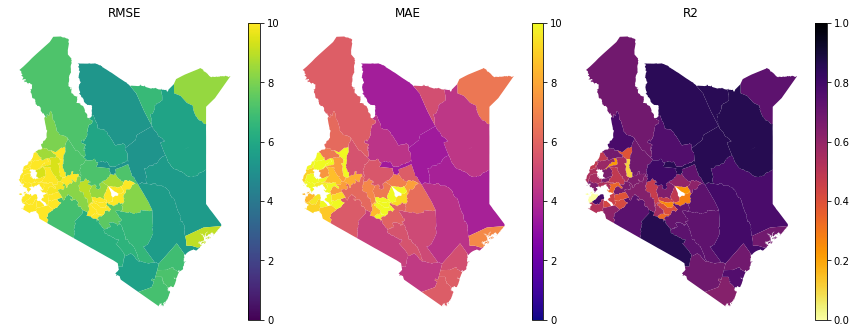

In [124]:
%autoreload 2
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'ealstm').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

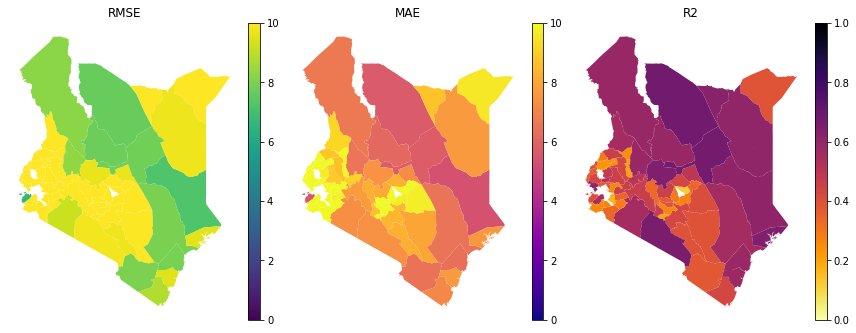

In [123]:
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'previous_month').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [39]:
kwargs = {}
ll = kwargs['rmse_vmin'] if 'rmse_vmin' in kwargs else None
ll

### Region timeseries

In [125]:
np.unique(all_gdf.region_name)

array(['BARINGO', 'BOMET', 'BONDO', 'BUNGOMA', 'BURET', 'BUSIA',
       'BUTERE/MUMIAS', 'CENTRAL KISII', 'EMBU', 'GARISSA', 'GUCHA',
       'HOMA BAY', 'ISIOLO', 'KAJIADO', 'KAKAMEGA', 'KEIYO', 'KERICHO',
       'KIAMBU', 'KILIFI', 'KIRINYAGA', 'KISUMU', 'KITUI', 'KOIBATEK',
       'KURIA', 'KWALE', 'LAIKIPIA', 'LAMU', 'LUGARI', 'MACHAKOS',
       'MAKUENI', 'MALINDI', 'MANDERA', 'MARAGUA', 'MARAKWET', 'MARSABIT',
       'MBEERE', 'MERU CENTRAL', 'MERU NORTH', 'MERU SOUTH', 'MIGORI',
       'MOMBASA', 'MOYALE', 'MT ELGON', 'MURANGA', 'MWINGI', 'NAIROBI',
       'NAKURU', 'NANDI', 'NAROK', 'NYAMIRA', 'NYANDARUA', 'NYANDO',
       'NYERI', 'RACHUONYO', 'SAMBURU', 'SIAYA', 'SUBA', 'TAITA TAVETA',
       'TANA RIVER', 'TESO', 'THARAKA', 'THIKA', 'TRANS MARA',
       'TRANS NZOIA', 'TURKANA', 'UASIN GISHU', 'VIHIGA', 'WAJIR',
       'WEST POKOT'], dtype=object)

In [230]:
from typing import List

region = 'MARSABIT'

def plot_region_time_series(region: str, ax=None, model: List[str] = ['ealstm']):
    times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].datetime 
    obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].true_mean_value
    rnn_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].predicted_mean_value
    ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value
    lr_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_regression')].predicted_mean_value
    ln_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_network')].predicted_mean_value
    bline_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'previous_month')].predicted_mean_value
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    df_dict = {'obs' : obs_ts.values}
    
    if 'lstm' in model:
        df_dict['lstm'] = rnn_ts.values
    if 'ealstm' in model:
        df_dict['ealstm'] = ealstm_ts.values
    if 'lr' in model:
        df_dict['lr'] = lr_ts.values
    if 'ln' in model:
        df_dict['ln'] = ln_ts.values
    if 'baseline' in model:
        df_dict['baseline'] = bline_ts.values

    pd.DataFrame(df_dict, index=times).iloc[1:].plot(ax=ax)

    ax.set_ylim(0, 100)
    ax.set_title(f'{region} Predicted vs. Modelled');
    
    return fig, ax


def plot_region_seasonality(region, ax=None):
    ts = (
        all_df
        .loc[:, ['datetime', region]
        ].set_index('datetime')
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean NDVI');
    
    return fig, ax


def plot_region_vs_observed_seasonality(region, model, ax=None):
    ts = (
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region), 
            ['datetime', 'true_mean_value', 'predicted_mean_value']
        ].set_index('datetime')
    ).rename(
        columns={'true_mean_value': 'Observed', 'predicted_mean_value': f'Predicted ({model.upper()})'}
    )
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle for {region} District')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean VCI');

    return fig, ax

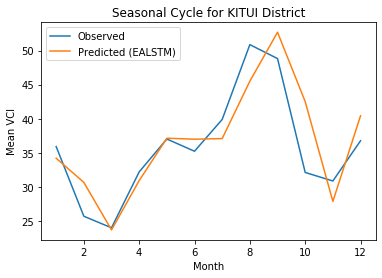

In [232]:
plot_region_vs_observed_seasonality(region='KITUI', model='ealstm');

### Northern Counties

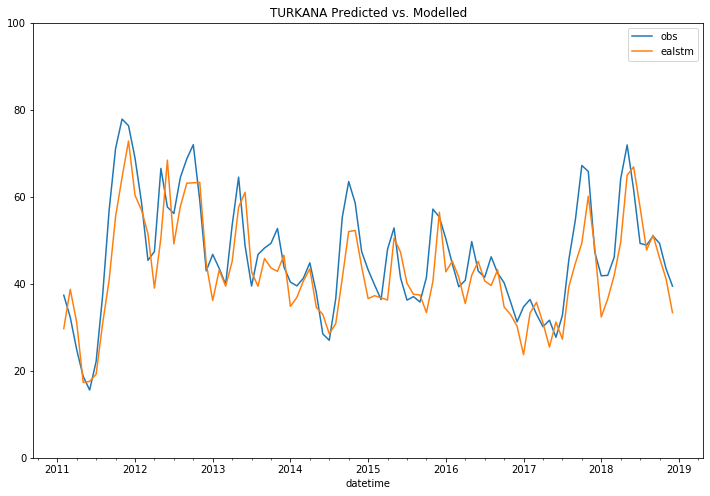

In [240]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_region_time_series(region='TURKANA', ax=ax, model=['ealstm']);

# plot_region_time_series(region='MARSABIT', ax=ax, model=['ln', 'ealstm']);
# plot_region_time_series(region='WAJIR');
# plot_region_time_series(region='MANDERA');

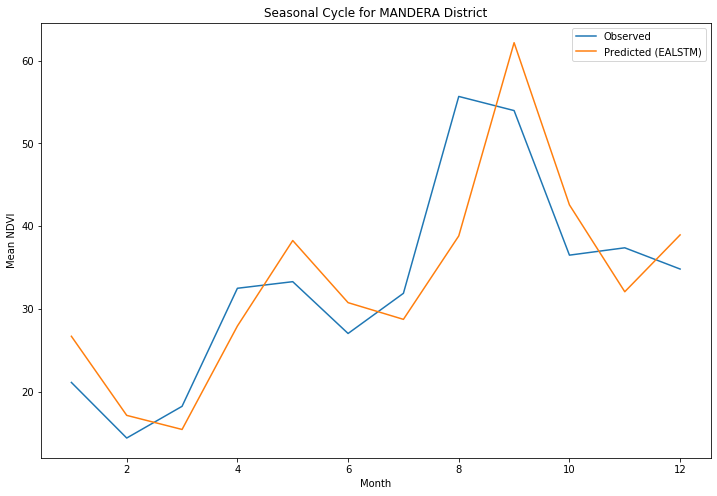

In [139]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plot_region_seasonality(region='TURKANA', ax=ax);
# plot_region_seasonality(region='MARSABIT', ax =ax);
# plot_region_seasonality(region='WAJIR', ax =ax);
# plot_region_seasonality(region='MANDERA', ax =ax);

fig, ax = plt.subplots(figsize=(12, 8))
plot_region_vs_observed_seasonality(region='MANDERA', model='ealstm', ax=ax);


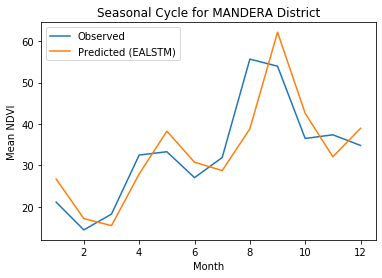

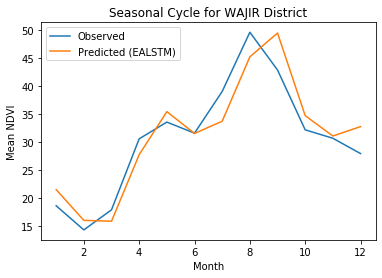

In [140]:
plot_region_vs_observed_seasonality(region='MANDERA', model='ealstm');
plot_region_vs_observed_seasonality(region='WAJIR', model='ealstm');

### Southern Counties

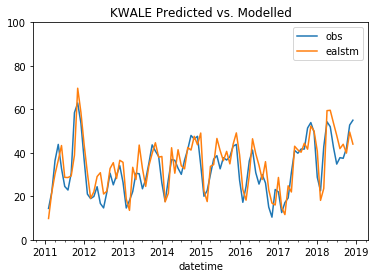

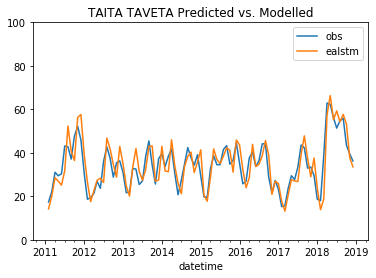

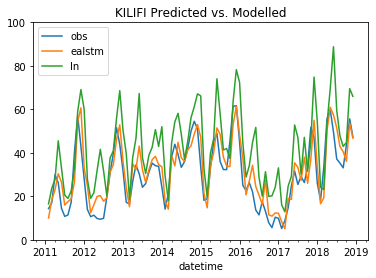

In [237]:
plot_region_time_series(region='KWALE');
plot_region_time_series(region='TAITA TAVETA');
plot_region_time_series(region='KILIFI', model=['ln', 'ealstm']);

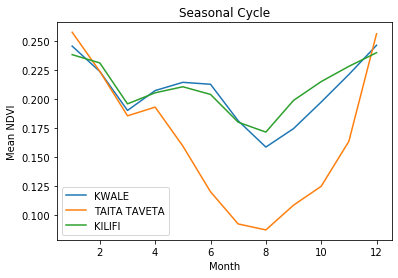

In [41]:
fig, ax = plt.subplots()
plot_region_seasonality(region='KWALE', ax=ax);
plot_region_seasonality(region='TAITA TAVETA', ax=ax);
plot_region_seasonality(region='KILIFI', ax=ax);

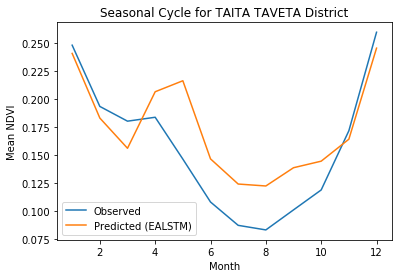

In [101]:
plot_region_vs_observed_seasonality(region='TAITA TAVETA', model='ealstm');

### Eastern Counties

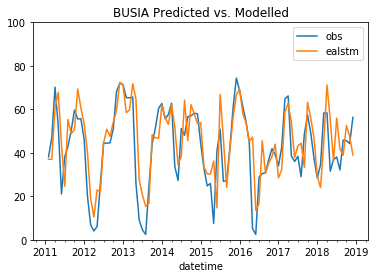

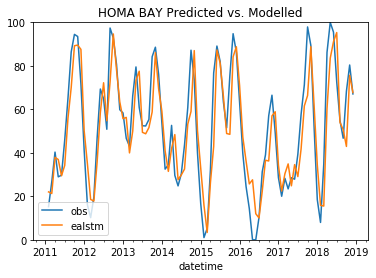

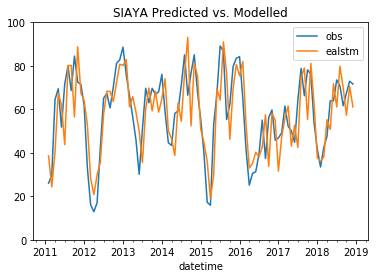

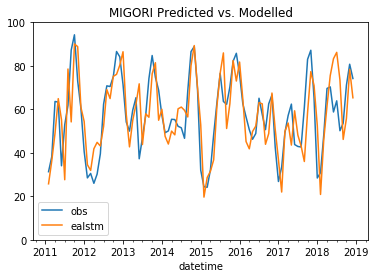

In [134]:
plot_region_time_series(region='BUSIA');
plot_region_time_series(region='HOMA BAY');
plot_region_time_series(region='SIAYA');
plot_region_time_series(region='MIGORI');

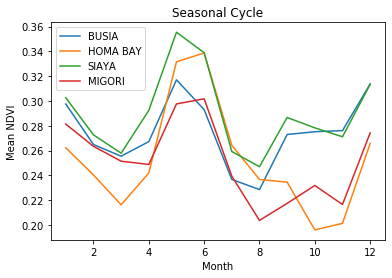

In [42]:
fig, ax = plt.subplots()
plot_region_seasonality(ax=ax, region='BUSIA')
plot_region_seasonality(ax=ax, region='HOMA BAY')
plot_region_seasonality(ax=ax, region='SIAYA')
plot_region_seasonality(ax=ax, region='MIGORI');

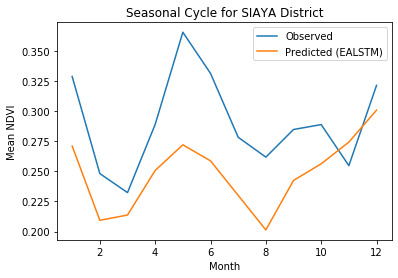

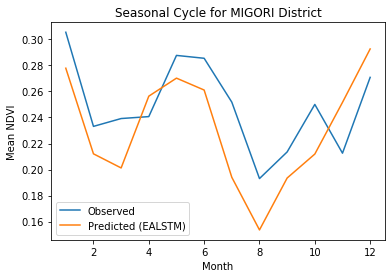

In [102]:
plot_region_vs_observed_seasonality(region='SIAYA', model='ealstm');
plot_region_vs_observed_seasonality(region='MIGORI', model='ealstm');

### Rift Valley 

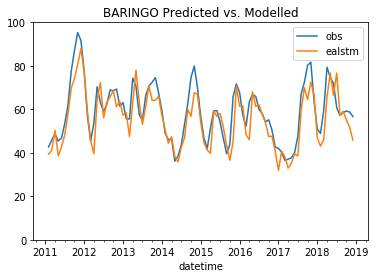

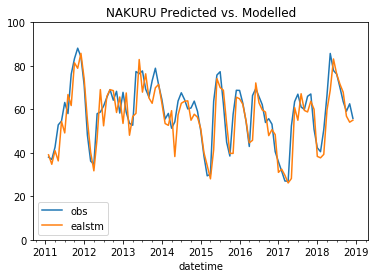

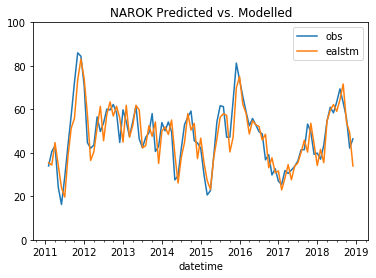

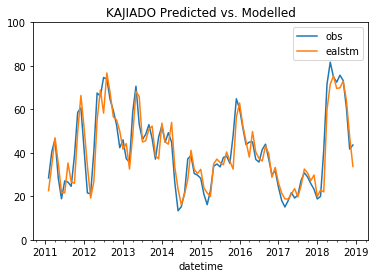

In [135]:
plot_region_time_series(region='BARINGO');
plot_region_time_series(region='NAKURU');
plot_region_time_series(region='NAROK');
plot_region_time_series(region='KAJIADO');

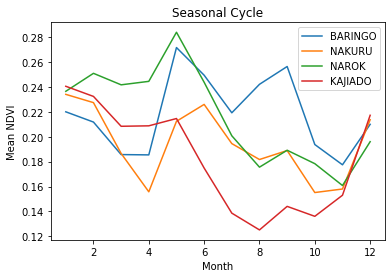

In [44]:
fig, ax = plt.subplots()
plot_region_seasonality(ax=ax, region='BARINGO');
plot_region_seasonality(ax=ax, region='NAKURU');
plot_region_seasonality(ax=ax, region='NAROK');
plot_region_seasonality(ax=ax, region='KAJIADO');

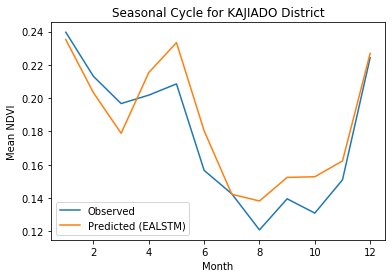

In [103]:
plot_region_vs_observed_seasonality(region='KAJIADO', model='ealstm');

### Central Highlands, High Potential Zone

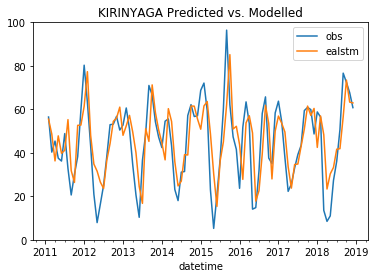

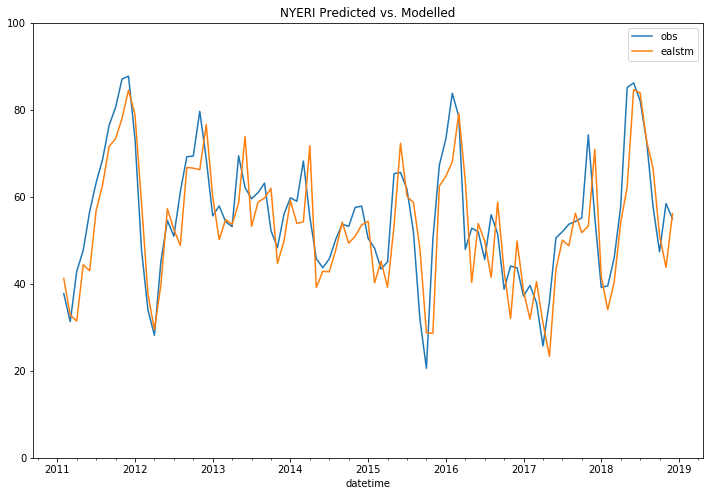

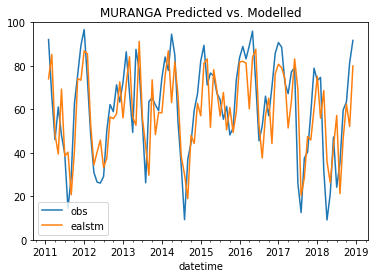

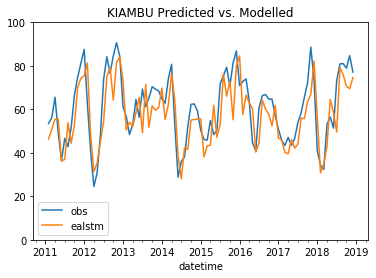

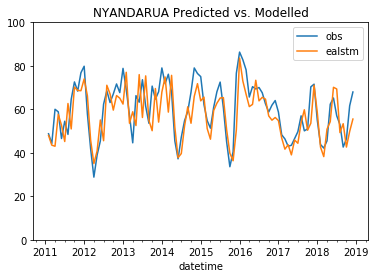

In [136]:
plot_region_time_series(region='KIRINYAGA');
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='NYERI', ax=ax);
plot_region_time_series(region='MURANGA');
plot_region_time_series(region='KIAMBU');
plot_region_time_series(region='NYANDARUA');

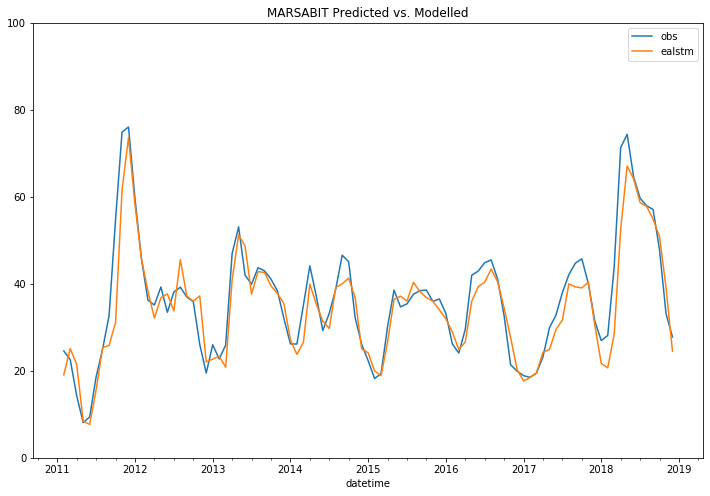

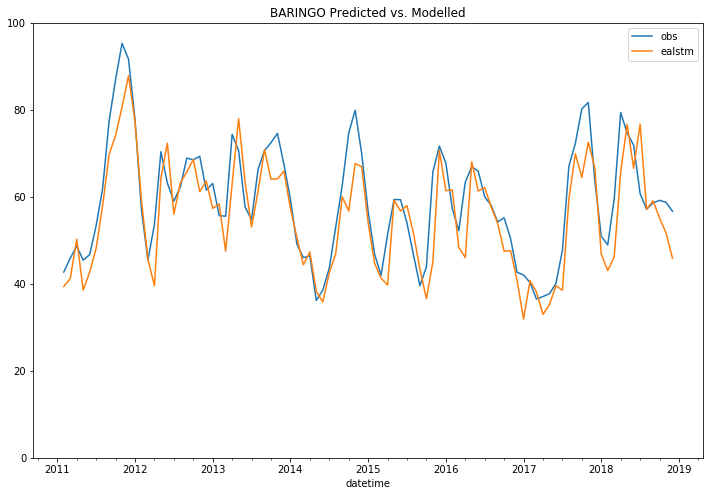

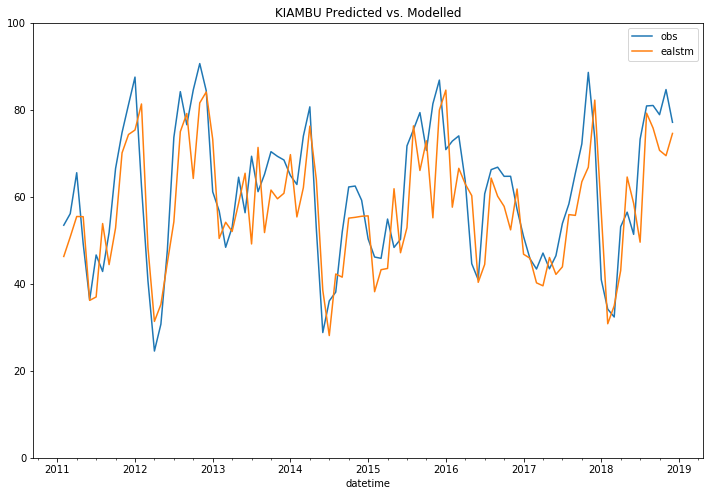

In [137]:
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='MARSABIT', ax=ax);
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='BARINGO', ax=ax);
fig, ax = plt.subplots(figsize=(12,8))
plot_region_time_series(region='KIAMBU', ax=ax);


In [367]:
regions = ['TURKANA', 'MANDERA', 'SAMBURU', 'GARISSA', 'MARSABIT', 'WAJIR', 'TANA RIVER', 'WEST POKOT','ISIOLO', 'KITUI', 'MOYALE']
model = 'ealstm'
for region in regions:
    fig, ax = plt.subplots(figsize=(12,8))
    plot_region_time_series(region=region, ax=ax);
    fig.savefig(f'/Users/tommylees/Downloads/{model}_{region}_sdfhsdhsdfg.png', transparent=True)
    plt.close()

## For our test counties

In [267]:
from sklearn.metrics import r2_score
from typing import Dict

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def rolling_average(district_csv: pd.DataFrame) -> Dict[str, float]:
    """Over three months"""
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']

    district_csv['month'] = pd.to_datetime(district_csv.datetime).dt.month

    output_dict: Dict[str: float] = {}

    for district in relevant_districts:
        district_df = district_csv[district_csv.region_name == district.upper()]
        true, predicted = [], []
        for i in range(1, 12 - 1):
            min_month = i
            max_month = i + 3
            submonth = district_df[(district_df.month >= min_month) & (district_df.month < max_month)]
            predicted.append(submonth.predicted_mean_value.mean())
            true.append(submonth.true_mean_value.mean())
        district_score = r2(true, predicted)
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    
    return output_dict

In [268]:
print('Performance for EALSTM')
rolling_average(all_gdf[all_gdf.model == 'ealstm']);
print()

print('Performance for Persistence')
rolling_average(all_gdf[all_gdf.model == 'previous_month']);
print()

print('Performance for RNN')
rolling_average(all_gdf[all_gdf.model == 'rnn']);
print()

Performance for EALSTM
For Mandera, r2 score: 0.9285030987864911
For Marsabit, r2 score: 0.9790304574600829
For Turkana, r2 score: 0.8505720902917523
For Wajir, r2 score: 0.9494434497738151

Performance for Persistence
For Mandera, r2 score: 0.7418834628995075
For Marsabit, r2 score: 0.8156893342781715
For Turkana, r2 score: 0.6829170118607626
For Wajir, r2 score: 0.7708332053175011

Performance for RNN
For Mandera, r2 score: 0.8826001126667086
For Marsabit, r2 score: 0.9754361813286556
For Turkana, r2 score: 0.8224845706127023
For Wajir, r2 score: 0.9205917636033555



### Look at R2 values

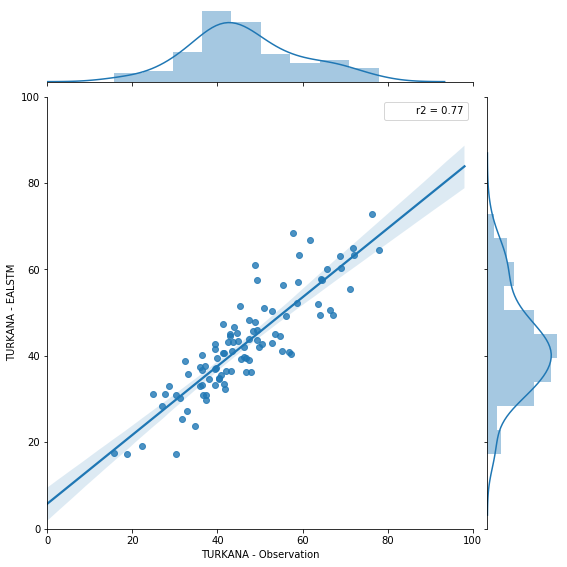

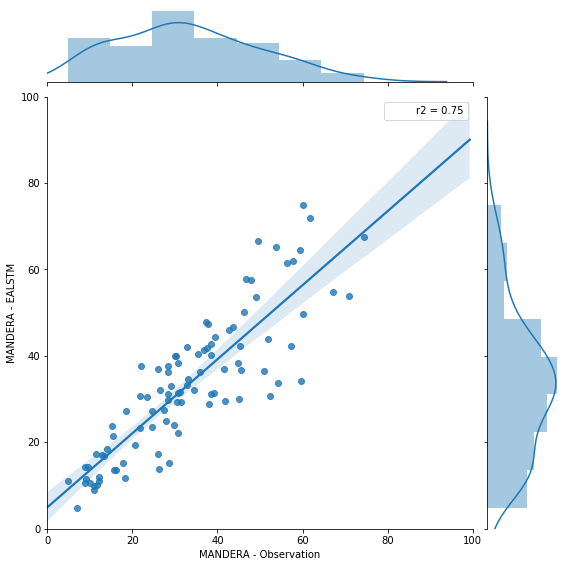

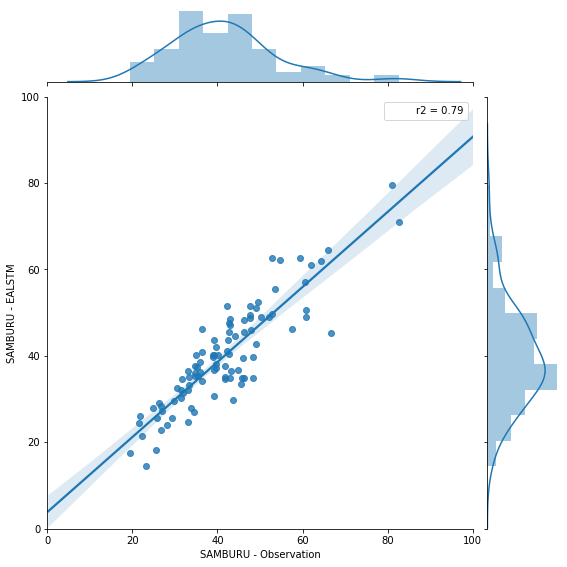

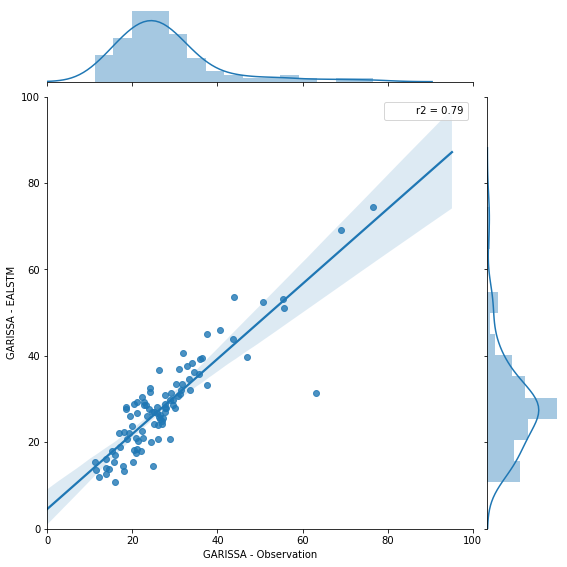

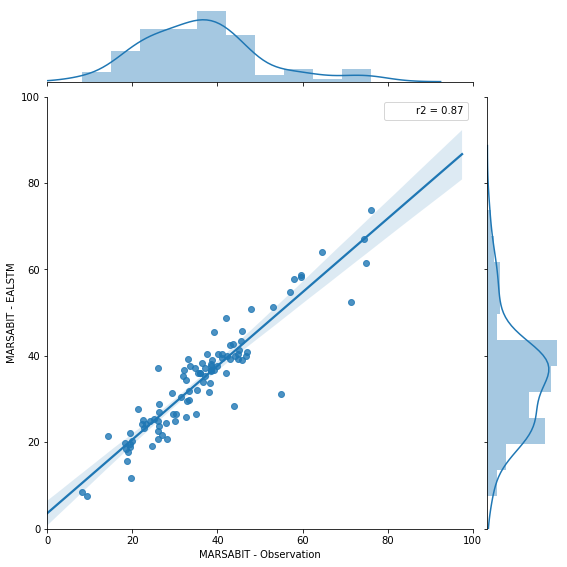

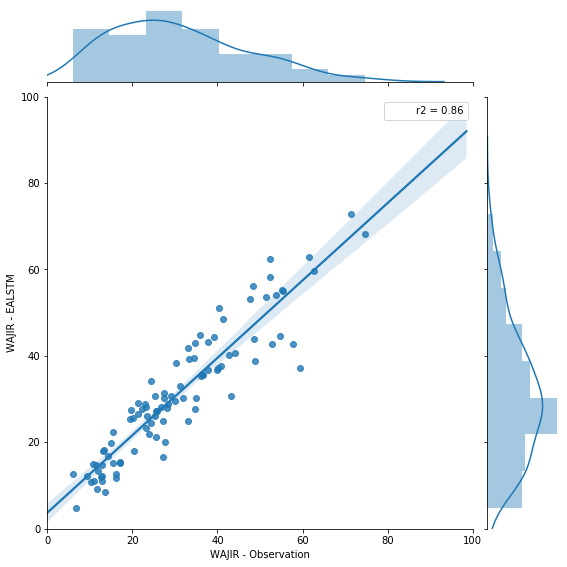

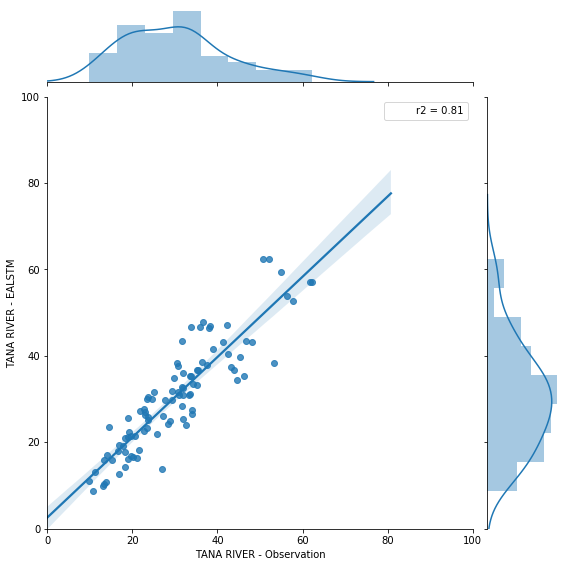

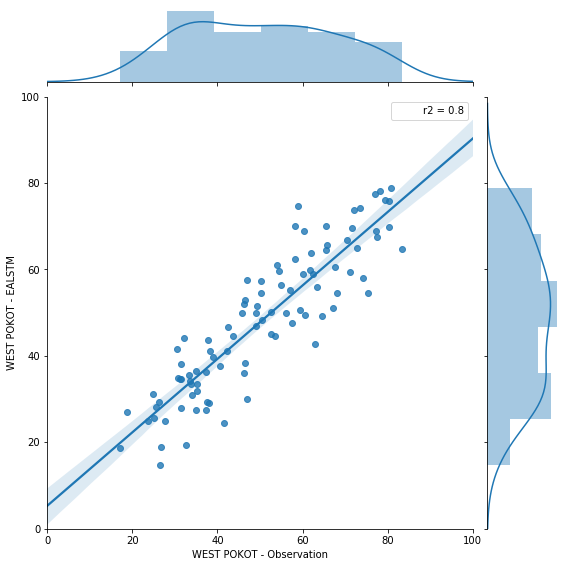

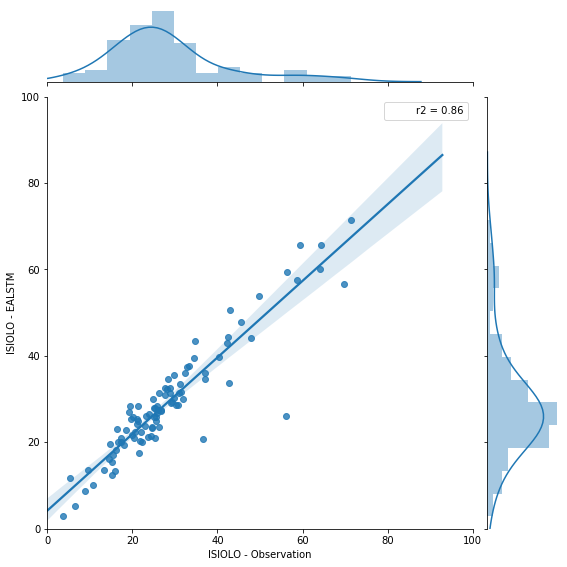

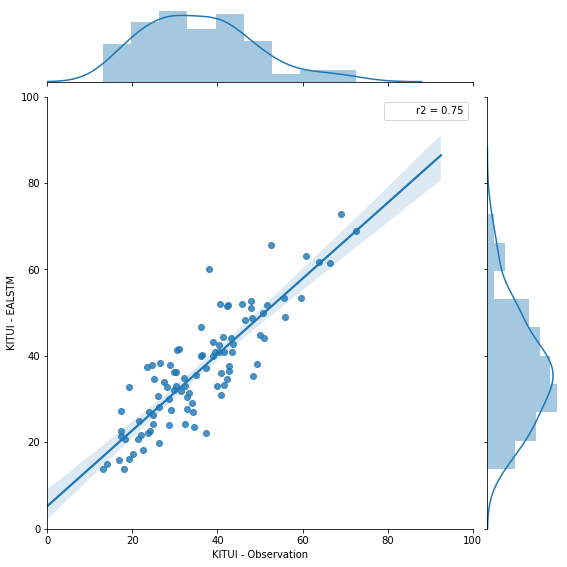

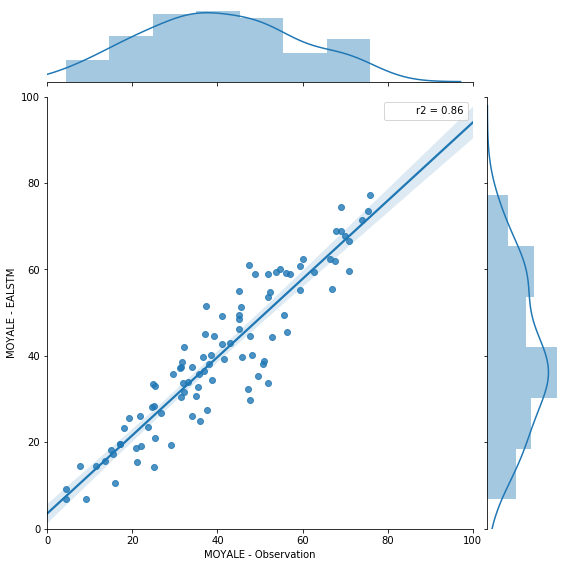

In [387]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2


model = 'ealstm'
region = 'TURKANA'

# TURKANA explore

def plot_region_performance(model: str, region: str, kind='reg'):
    df = pd.DataFrame(
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region),
            ['datetime', 'predicted_mean_value', 'true_mean_value']
        ].set_index('datetime')
    )

    # sns.scatterplot(x='true_mean_value', y='predicted_mean_value', data=turkana)
    # sns.lmplot(x='true_mean_value', y='predicted_mean_value', data=turkana)

    sns.jointplot(
        x='true_mean_value', y='predicted_mean_value', 
        data=df, kind=kind, stat_func=r2
    )
    
    ax = plt.gca()
    ax.set_xlabel(f'{region} - Observation')
    ax.set_ylabel(f'{region} - {model.upper()}');
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    fig = plt.gcf()
    # fig.set_size_inches(11.7, 8.27)
    fig.set_size_inches(8.27, 8.27)

    return fig, ax


regions = ['TURKANA', 'MANDERA', 'SAMBURU', 'GARISSA', 'MARSABIT', 'WAJIR', 'TANA RIVER', 'WEST POKOT','ISIOLO', 'KITUI', 'MOYALE']
model = 'ealstm'
for region in regions:
    fig, ax = plot_region_performance(model=model, region=region);
#     fig.savefig(f'/Users/tommylees/Downloads/{model}_{region}_sdfgsdg.png', transparent=True)
#     plt.close()

# plot_region_performance(model='ealstm', region='TURKANA');
# plot_region_performance(model='ealstm', region='MARSABIT');
# plot_region_performance(model='ealstm', region='MANDERA', kind='reg');
# plot_region_performance(model='previous_month', region='WAJIR');
# # plot_region_performance(model='ealstm', region='HOMA BAY');

In [335]:
monthly_scores.loc[monthly_scores.metric == 'rmse', :].mean()
monthly_scores.loc[monthly_scores.metric == 'r2', :].mean()

ealstm                  0.591288
linear_network          0.236946
linear_regression      -4.816546
month                   6.500000
previous_month          0.407519
rnn                     0.576504
year                 2018.000000
dtype: float64

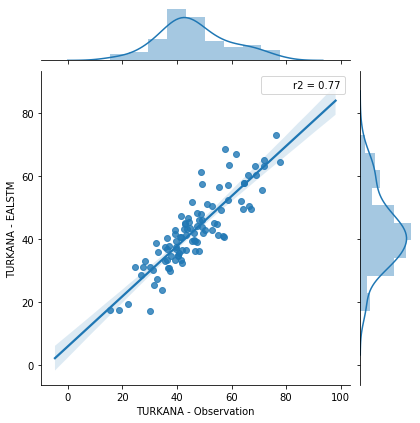

In [329]:
# sns.scatterplot(x='true_mean_value', y='predicted_mean_value', data=turkana)
# sns.lmplot(x='true_mean_value', y='predicted_mean_value', data=turkana)
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(
    x='true_mean_value', y='predicted_mean_value', 
    data=turkana, kind="reg", stat_func=r2
)
ax = plt.gca()
ax.set_xlabel(f'{region} - Observation')
ax.set_ylabel(f'{region} - {model.upper()}');

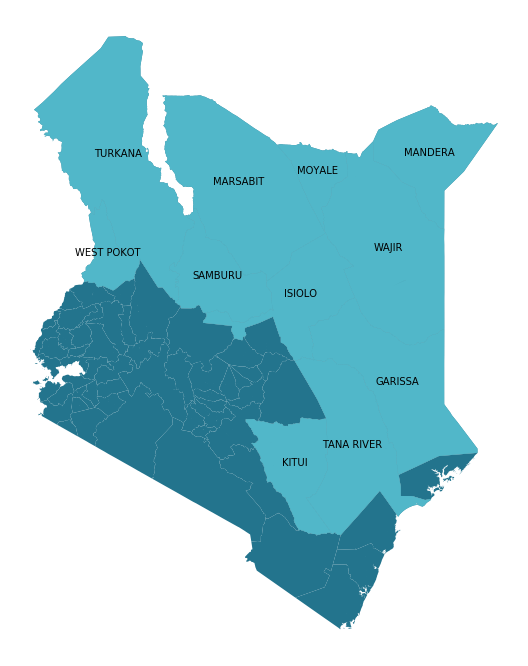

In [365]:
from typing import List
scale = 1.5
# def highlight_selected_regions(regions: List[str]):

fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
regions = ['MARSABIT', 'TURKANA', 'WAJIR', 'MANDERA', 'SAMBURU', 'ISIOLO', 'LAIKIPIA', 'MOYALE', 'KAJIADO']
regions = ['TURKANA', 'MANDERA', 'SAMBURU', 'GARISSA', 'MARSABIT', 'WAJIR', 'TANA RIVER', 'WEST POKOT','ISIOLO', 'KITUI', 'MOYALE']
gdf = all_gdf.loc[(all_gdf.model=='ealstm') & (all_gdf.datetime == '2011-01-31')]
gdf.plot(ax=ax, color='#23748d')
gdf_ = gdf.loc[np.isin(gdf.region_name, regions)]
gdf_.plot(color='#57bfd0', ax=ax, alpha=0.9)

# https://stackoverflow.com/a/38902492/9940782
# gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
# gdf['coords'] = [coords[0] for coords in gdf['coords']]
# for idx, row in gdf.iterrows():
#     plt.annotate(s=row['region_name'], xy=row['coords'],
#                  horizontalalignment='center')
gdf_.apply(
    lambda x: ax.annotate(
        s=x.region_name, xy=x.geometry.centroid.coords[0], ha='center'
    ), 
    axis=1
);


ax.set_axis_off()

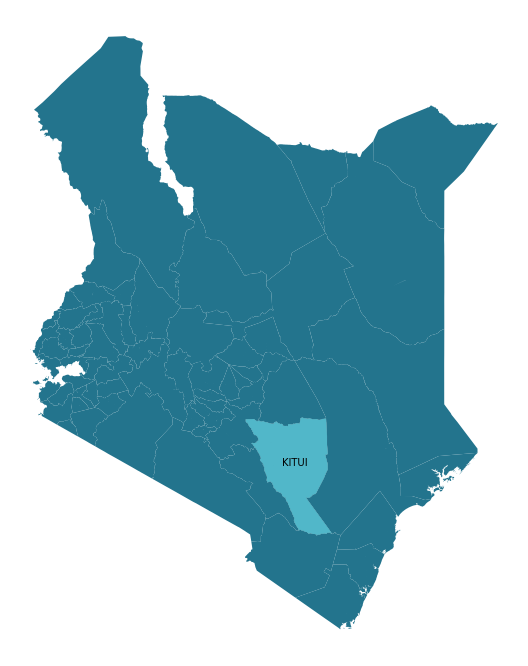

In [391]:
from typing import List
scale = 1.5

def highlight_selected_regions(regions: List[str]):
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
    gdf = all_gdf.loc[(all_gdf.model=='ealstm') & (all_gdf.datetime == '2011-01-31')]

    for region in regions:
        gdf.plot(ax=ax, color='#23748d')

        gdf_ = gdf.loc[gdf.region_name == region]
        gdf_.plot(color='#57bfd0', ax=ax, alpha=0.9)

        # https://stackoverflow.com/a/38902492/9940782
        # gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
        # gdf['coords'] = [coords[0] for coords in gdf['coords']]
        # for idx, row in gdf.iterrows():
        #     plt.annotate(s=row['region_name'], xy=row['coords'],
        #                  horizontalalignment='center')
        gdf_.apply(
            lambda x: ax.annotate(
                s=x.region_name, xy=x.geometry.centroid.coords[0], ha='center'
            ), 
            axis=1
        );


        ax.set_axis_off()
#         fig.savefig(f'/Users/tommylees/Downloads/{region}_maps.png', transparent=True)
#         plt.close()



regions = ['MARSABIT', 'TURKANA', 'WAJIR', 'MANDERA', 'SAMBURU', 'ISIOLO', 'LAIKIPIA', 'MOYALE', 'KAJIADO']
regions = ['TURKANA', 'MANDERA', 'SAMBURU', 'GARISSA', 'MARSABIT', 'WAJIR', 'TANA RIVER', 'WEST POKOT','ISIOLO', 'KITUI', 'MOYALE']

highlight_selected_regions(regions=['KITUI'])

# What about specific events / hits misses?

In [142]:
times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].datetime 
obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].true_mean_value
rnn_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].predicted_mean_value
ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value
lr_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_regression')].predicted_mean_value
ln_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_network')].predicted_mean_value

In [144]:
y_train
y_test
bline_pred

<xarray.DataArray 'preds' (time: 96, lat: 45, lon: 35)>
dask.array<shape=(96, 45, 35), dtype=float64, chunksize=(1, 45, 35)>
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2011-01-31 2011-02-28 ... 2018-12-31

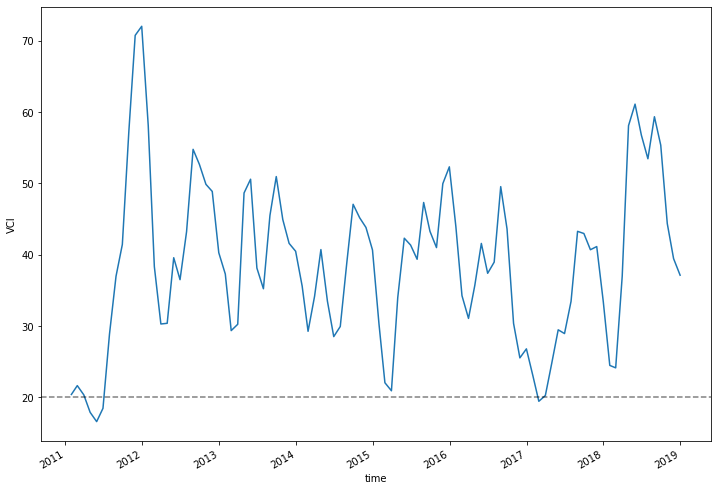

In [180]:
fig, ax = plt.subplots(figsize=(12, 8))

y_test.median(dim=['lat', 'lon']).VCI.plot(ax=ax);
ax.axhline(20, ls='--', color='black', alpha=0.5);

Text(0.5, 1.0, 'BUSIA')

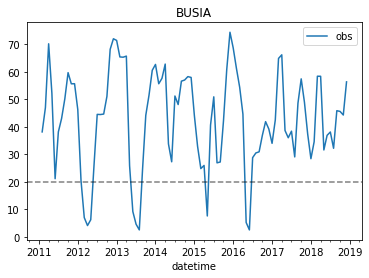

In [183]:
region = 'BUSIA'
times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].datetime
obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].true_mean_value
fig, ax = plt.subplots()
df_dict = {'obs' : obs_ts.values}
pd.DataFrame(df_dict, index=times).iloc[1:].plot(ax=ax)
ax.axhline(20, ls='--', color='black', alpha=0.5);
ax.set_title(region)

In [192]:
def proportion_below_thresh(thresh: float, da: xr.DataArray, name: str):
    print(f'The Proportion of values < {thresh} in {name}')
    print(f'{1 - (da.where(da <= 20).isnull().mean()).values:.2f}')

proportion_below_thresh(20, y_test.VCI, 'y_test') 
proportion_below_thresh(20, y_train.VCI, 'y_train')
# proportion_below_thresh(20, bline_pred, 'Baseline')
# proportion_below_thresh(20, lr_pred, 'lr_pred')
proportion_below_thresh(20, ln_pred, 'ln_pred')
proportion_below_thresh(20, rnn_pred, 'rnn_pred')
proportion_below_thresh(20, ealstm_pred, 'ealstm_pred')

The Proportion of values < 20 in y_test
0.19
The Proportion of values < 20 in y_train
0.23
The Proportion of values < 20 in ln_pred
0.07
The Proportion of values < 20 in rnn_pred
0.16
The Proportion of values < 20 in ealstm_pred
0.16


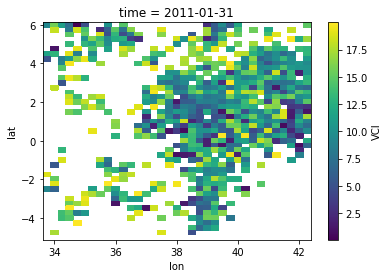

In [193]:
thresh_20 = y_test.VCI.where(y_test.VCI <= 20)
thresh_mask = thresh_20.isnull()
thresh_20.isel(time=0).plot()

In [287]:
def confusion_matrix(obs_da, pred_da):
    fp_mask = (pred_da <= 20) & (obs_da > 20)
    fn_mask = (pred_da > 20) & (obs_da <= 20)
    tp_mask = (pred_da <= 20) & (obs_da <= 20)
    tn_mask = (pred_da > 20) & (obs_da > 20)
    
    fp_obs = obs_da.where(fp_mask)
    fn_obs = obs_da.where(fn_mask)
    tp_obs = obs_da.where(tp_mask)
    tn_obs = obs_da.where(tn_mask)
    
    fp_pred = pred_da.where(fp_mask)
    fn_pred = pred_da.where(fn_mask)
    tp_pred = pred_da.where(tp_mask)
    tn_pred = pred_da.where(tn_mask)
    
    # rates
    fp_rate = 1 - (fp_obs.isnull().values.mean())
    fn_rate = 1 - (fn_obs.isnull().values.mean())
    tp_rate = 1 - (tp_obs.isnull().values.mean())
    tn_rate = 1 - (tn_obs.isnull().values.mean())
    
    rates =  dict(
        zip(
            ['fp_rate', 'fn_rate', 'tp_rate', 'tn_rate'], 
            [fp_rate, fn_rate, tp_rate, tn_rate]
        )
    )
    
    # counts
    fp_count = (~fp_obs.isnull()).values.sum()
    fn_count = (~fn_obs.isnull()).values.sum()
    tp_count = (~tp_obs.isnull()).values.sum()
    tn_count = (~tn_obs.isnull()).values.sum()

    counts = dict(
        zip(
            ['fp_count', 'fn_count', 'tp_count', 'tn_count'], 
            [fp_count, fn_count, tp_count, tn_count]
        )
    )

    return rates, counts


obs_da = y_test.VCI
pred_da = ealstm_pred
confusion_matrix(obs_da, pred_da)

({'fp_rate': 0.04120370370370374,
  'fn_rate': 0.06475529100529098,
  'tp_rate': 0.12033068783068779,
  'tn_rate': 0.6429563492063493},
 {'fp_count': 6230, 'fn_count': 9791, 'tp_count': 18194, 'tn_count': 97215})

# What about the morris gradients

In [279]:
from src.models import load_model

In [392]:
model_path = data_dir / 'models' / 'one_month_forecast' / 'ealstm' / 'model.pt'
assert model_path.exists()

ealstm = load_model(model_path)

# dl = ealstm.get_dataloader('train')
test_dl = next(iter(
    ealstm.get_dataloader(mode="test", to_tensor=True, shuffle_data=True)
))

In [393]:
outputs = []

for key, val in test_dl.items():
    outputs.append(ealstm.get_morris_gradient(val.x))

RuntimeError: size mismatch, m1: [1334 x 18], m2: [22 x 128] at ../aten/src/TH/generic/THTensorMath.cpp:197

# Input data

In [293]:
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 449)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2018-12-31
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
Data variables:
    VCI      (time, lat, lon) float64 39.36 18.57 19.15 ... 21.15 60.27 22.19
    p84.162  (time, lat, lon) float64 9.101e-06 -2.29e-05 5.122e-06 ... nan nan
    pev      (time, lat, lon) float64 -0.006845 -0.006982 -0.006779 ... nan nan
    sp       (time, lat, lon) float64 8.878e+04 8.945e+04 8.825e+04 ... nan nan
    t2m      (time, lat, lon) float64 296.8 297.3 296.2 294.4 ... nan nan nan
    tp       (time, lat, lon) float64 1.283e-05 1.466e-05 5.499e-06 ... nan nan
    precip   (time, lat, lon) float64 2.911e-08 2.504e-08 0.2845 ... nan nan nan
    ndvi     (time, lat, lon) float64 0.1729 0.1605 0.1713 ... nan nan nan
    E        (time, lat, lon) float64 14.84 10

In [294]:
ds.precip

<xarray.DataArray 'precip' (time: 449, lat: 45, lon: 35)>
array([[[2.911272e-08, 2.504078e-08, ...,          nan,          nan],
        [2.933301e-08, 2.208068e-08, ...,          nan,          nan],
        ...,
        [1.945617e+02, 1.800572e+02, ..., 8.961629e+00, 1.033433e+01],
        [1.952802e+02, 1.652386e+02, ..., 1.770580e+01, 8.885622e+00]],

       [[1.686568e+00, 1.155798e+00, ...,          nan,          nan],
        [1.644238e+00, 1.009421e+00, ...,          nan,          nan],
        ...,
        [1.358513e+02, 1.216364e+02, ..., 1.415676e+01, 1.454688e+01],
        [1.499788e+02, 1.380385e+02, ..., 2.694078e+01, 1.781732e+01]],

       ...,

       [[6.547739e+01, 4.055690e+01, ...,          nan,          nan],
        [9.955605e+01, 5.667866e+01, ...,          nan,          nan],
        ...,
        [3.539116e+01, 4.129999e+01, ..., 3.428290e+01, 2.203147e+01],
        [4.831512e+01, 5.931445e+01, ..., 1.495671e+01, 1.675682e+01]],

       [[         nan,          